In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d,BatchNorm1d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter   
import torchvision.models as tvmodels

from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt

import librosa
import os

In [2]:
base_path = 'augmented_stft_npy_files//'
with open(base_path+'trainX.npy', 'rb') as f:
    trainX = np.load(f, allow_pickle=True)
with open(base_path+'trainY.npy', 'rb') as f:
    trainY = np.load(f, allow_pickle=True)
    
with open(base_path+'devX.npy', 'rb') as f:
    devX = np.load(f, allow_pickle=True)
with open(base_path+'devY.npy', 'rb') as f:
    devY = np.load(f, allow_pickle=True)
    
with open(base_path+'testX.npy', 'rb') as f:
    testX = np.load(f, allow_pickle=True)
with open(base_path+'testY.npy', 'rb') as f:
    testY = np.load(f, allow_pickle=True)

In [3]:
trainX[0].shape

torch.Size([104, 241])

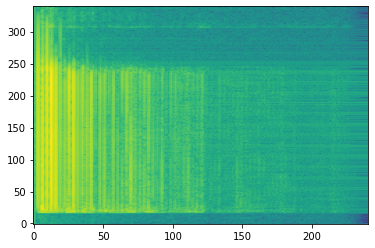

In [4]:

plt.imshow(trainX[1], aspect='auto', origin='lower',)
    

## The shape of each mfcc graph is (x, 24)
## The shape of each stft graph is (x, 241)


We find the maximum x in trainX, devX and testX, and pad the short graphs to the maximun length by repreating the short graph multiple times.

In [5]:
def max_len(trainX):
    len_list = []
    for i in range(len(trainX)):
        len_list.append(trainX[i].shape[0])
    print('Samples: ',len(len_list),'maximum len: ', max(len_list))

In [6]:
max_len(trainX)
max_len(devX)
max_len(testX)


Samples:  11300 maximum len:  2068
Samples:  1000 maximum len:  2068
Samples:  1600 maximum len:  2050


### pad all mfcc graphs to the size of (646, 24)
### pad all stft graphs to the size of (2068, 241)


In [7]:
def pad_graph(maximum, feature_size, a):
    
    # a is the tensor to be padded
    
    pad_row = maximum-a.shape[0]
    pad_times = int(pad_row/a.shape[0])
    remain_rows = maximum - pad_times * a.shape[0] - a.shape[0]
    b = torch.stack([a for i in range(pad_times+1)]).reshape(-1,feature_size)
    b = torch.cat([b,a[:remain_rows,:]])
    return b

In [8]:
def batch_pad(maximum, feature_size, trainX):
    padded_trainX = [0 for i in range(len(trainX))]
    for i in range(len(trainX)):
        a = pad_graph(maximum, feature_size, trainX[i])
        padded_trainX[i] = torch.stack([a for j in range(3)])
    return np.array(padded_trainX)

In [9]:
padded_trainX = batch_pad(2068, 241,trainX)
padded_devX = batch_pad(2068, 241,devX)
padded_testX = batch_pad(2068, 241,testX)

/home/yingjie/anaconda3/envs/YJ_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  
/home/yingjie/anaconda3/envs/YJ_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


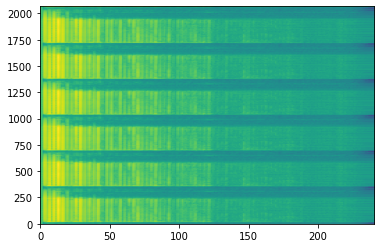

In [10]:
plt.imshow(padded_trainX[1][0], aspect='auto', origin='lower',)

## Dataloader

In [11]:
BATCH_SIZE = 8

In [12]:
class MyDataset(Dataset):
    def __init__(self, trainX, trainY):
        self.trainX = trainX
        self.trainY = trainY
    
    def __getitem__(self, idx):
        # return torch.FloatTensor(self.trainX[idx]), torch.FloatTensor(self.trainY[idx])
        return self.trainX[idx], self.trainY[idx]
        
    def __len__(self):
        assert np.array(self.trainX).shape[0] == np.array(self.trainY).shape[0]
        return np.array(self.trainX).shape[0]

In [13]:
data_loader_train = DataLoader(MyDataset(padded_trainX, trainY), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
data_loader_dev = DataLoader(MyDataset(padded_devX, devY), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
data_loader_test = DataLoader(MyDataset(padded_testX, testY), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [14]:
batch_train = iter(data_loader_train).next()
batch_train[0].shape

torch.Size([8, 3, 2068, 241])

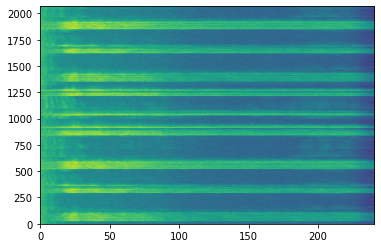

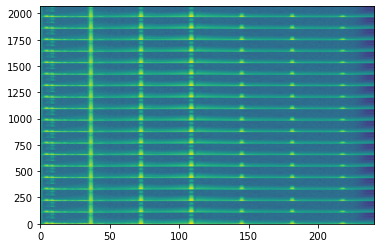

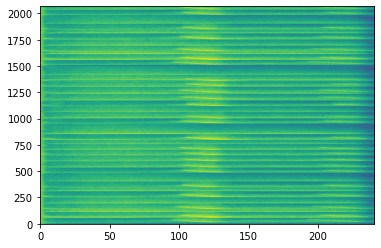

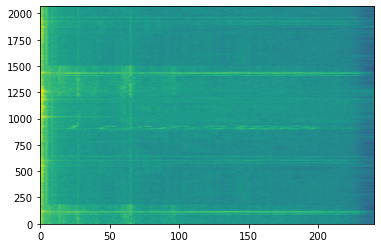

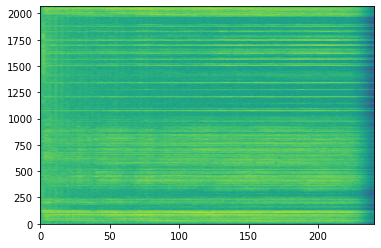

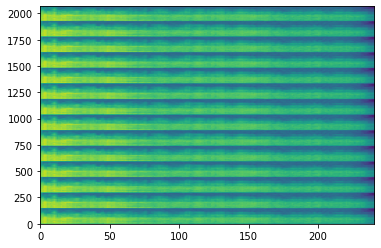

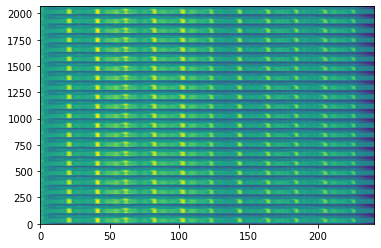

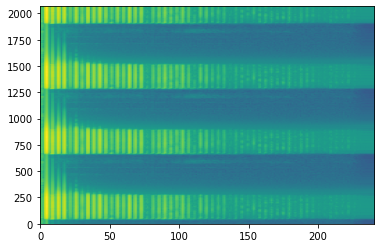

In [15]:
for i in range(8):
    fig, ax = plt.subplots()
    plt.imshow(batch_train[0][i][0], aspect='auto', origin='lower',)

In [16]:
class CNN(Module):
    def __init__(self):
        super(CNN, self).__init__()

        # self.cnn_layers = Sequential(
        #     # define a 2D convolutional layer
        #     Conv2d(1, 3, kernel_size=(5, 5), stride=1, padding=(0,0)),
        #     ReLU(inplace=True),
            # BatchNorm2d(32),
            # MaxPool2d(kernel_size=2, stride=2),
            
#             Conv2d(64, 32, kernel_size=(10, 10), stride=1, padding=(0,0)),
#             ReLU(inplace=True),

#             # Defining another 2D convolution layer
#             Conv2d(32, 16, kernel_size=(3, 3), stride=1),
#             ReLU(inplace=True),
#             # BatchNorm2d(16),
#             # MaxPool2d(kernel_size=2, stride=2),

#             # Defining another 2D convolution layer
#             Conv2d(16, 8, kernel_size=(3, 3), stride=1),
#             ReLU(inplace=True),
#             BatchNorm2d(8),
        # )
        
        self.vgg16 = tvmodels.vgg16(pretrained=True)

        self.linear_layers = Sequential(
            
            
            # Linear(3839840, 10000),
            # Linear(10000, 1000),
            
            Linear(1000,256),
            BatchNorm1d(256),
            ReLU(inplace=True),
            # Dropout(0.2),
            
            Linear(256, 128),
            BatchNorm1d(128),
            ReLU(inplace=True),
            # Dropout(0.1),
            
            Linear(128, 41),
            Softmax(dim=1)
        )
        
        
    # Defining the forward pass
    def forward(self, x):
        # x = self.cnn_layers(x)
        x = self.vgg16(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        # print(x.shape)
        # print(torch.max(x, dim=1))
        return x

In [17]:
class CNN_02(Module):
    def __init__(self):
        super(CNN_02, self).__init__()

        self.cnn_layers = Sequential(
            # define a 2D convolutional layer
            Conv2d(3, 64, kernel_size=(5, 5), stride=1, padding=(0,0)),
            ReLU(inplace=True),
            BatchNorm2d(64),
            MaxPool2d(kernel_size=2, stride=2),
            
            Conv2d(64, 32, kernel_size=(5, 5), stride=1, padding=(0,0)),
            ReLU(inplace=True),
            BatchNorm2d(32),
            MaxPool2d(kernel_size=2, stride=2),
        
            # Defining another 2D convolution layer
            Conv2d(32, 16, kernel_size=(3, 3), stride=1),
            ReLU(inplace=True),
            # BatchNorm2d(16),
            MaxPool2d(kernel_size=2, stride=2),

            # Defining another 2D convolution layer
            Conv2d(16, 8, kernel_size=(3, 3), stride=1),
            ReLU(inplace=True),
            # BatchNorm2d(8),
            MaxPool2d(kernel_size=2, stride=2),

        )
        
        

        self.linear_layers = Sequential(
            
            
            Linear(12192, 1000),
            BatchNorm1d(1000),
            ReLU(inplace=True),
            # Linear(10000, 1000),
            
            Linear(1000,256),
            BatchNorm1d(256),
            ReLU(inplace=True),
            # Dropout(0.2),
            
            Linear(256, 128),
            BatchNorm1d(128),
            ReLU(inplace=True),
            # Dropout(0.1),
            
            Linear(128, 41),
            Softmax(dim=1)
        )
        
        
    # Defining the forward pass
    def forward(self, x):
        x = self.cnn_layers(x)
        # x = self.vgg16(x)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = self.linear_layers(x)
        # print(x.shape)
        # print(torch.max(x, dim=1))
        return x

In [18]:
def compute_accuracy(output, target):
    target_hat = torch.max(output, dim=1).indices
    correct_num = int(sum(target_hat==target))
    total_num = target.shape[0]
    # print(target_hat, target, correct_num, total_num)
    return correct_num, total_num


def test(model, data_loader):
    model.eval()
    # accuracy
    with torch.no_grad():
        correct_list = []
        total_list = []
        for x, y in tqdm(data_loader):
            x = x.to(device)
            y = y.reshape(-1,).long().to(device)
            
            outputs = model(x)
            correct_num, total_num = compute_accuracy(outputs, y)
            correct_list.append(correct_num)
            total_list.append(total_num)
        
        accuracy = sum(correct_list) / sum(total_list)
        
 
    return accuracy

In [19]:
def train_net(model, train_data_iter,val_data_iter, epochs, save_path):
    model.train()
    for epoch in range(epochs):
        print("Epoch: ", epoch + 1)
        train_loss = []
        i=0
        for x,y in tqdm(train_data_iter):
            x = x.float().to(device)
            y = y.reshape(-1,).long().to(device)
            #x = x.float()
            #y = y.float() 
            out = model(x)
            loss = criterion(out, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
        dev_accuracy = test(model,val_data_iter) 

        print("train loss:", np.mean(train_loss), 'dev accuracy: ', dev_accuracy)
        
        torch.save(model, 'ckp/{}.ckp'.format(save_path))
        
    print("finish train")

In [20]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

epochs = 20
learning_rate = 0.001
save_path = 'padding_cnn_4conv_3linear_{}epoch_{}lr'.format(epochs, learning_rate)

model = CNN_02()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
model.to(device)

print(model)


train_net(model, data_loader_train, data_loader_dev, epochs=epochs, save_path=save_path)


CNN_02(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=12192, out_features=1000, bias=True)


  0%|          | 0/1413 [00:00<?, ?it/s]/home/yingjie/anaconda3/envs/YJ_env/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 125/125 [00:11<00:00, 11.31it/s]


train loss: 3.659307495719224 dev accuracy:  0.14
Epoch:  2


  7%|▋         | 102/1413 [00:18<03:54,  5.60it/s]


KeyboardInterrupt: 

In [22]:
def compute_F1(model, data_loader):
    
    labelencoder = joblib.load('labelencoder.pkl')

    with torch.no_grad():
       
        matrix_dict = {}
        
        for x, y in tqdm(data_loader):
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            
            
            for i in range(len(outputs)):
                
                target_hat = str(int(torch.max(outputs[i].reshape(-1,1), dim=0).indices))
                target = str(int(y[i]))
                if target_hat not in matrix_dict:
                    matrix_dict[target_hat] = {'TP':0, 'FP':0, 'FN':0}
                if target not in matrix_dict:
                    matrix_dict[target] = {'TP':0, 'FP':0, 'FN':0}

                if target_hat == target:
                    matrix_dict[target_hat]['TP'] += 1
                else:
                    matrix_dict[target_hat]['FP'] += 1
                    matrix_dict[target]['FN'] += 1
                
        f1_dict = {}
        for encoded_label in matrix_dict:
            true_label = labelencoder.inverse_transform([int(encoded_label)])[0]
            TP = matrix_dict[encoded_label]['TP']
            FP = matrix_dict[encoded_label]['FP']
            FN = matrix_dict[encoded_label]['FN']
            
            if TP == 0:
                precision =0
                recall = 0
                F1_score = 0
            else:
                precision = TP/(TP+FP)
                recall = TP/(TP+FN)
                F1_score = 2 * (precision * recall)/(precision + recall)            
    
            f1_dict[true_label] = {'precision':precision, 'recall':recall, 'f1-score':F1_score}
            
    # Macro-F1 : an arithmetic mean of the per-class F1-scores
    sum_F1 = 0
    for label in f1_dict:
        sum_F1 += f1_dict[label]['f1-score']
    macro_f1 = sum_F1 / len(f1_dict)
    
    return macro_f1, f1_dict

In [25]:

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = torch.load('ckp/padding_vgg16_50epoch_0.001lr.ckp')
print('Testing')
test_accuracy = test(model, data_loader_test)
macro_f1, f1_dict = compute_F1(model, data_loader_test)
print('Test accuracy: {0:.2f}'.format(test_accuracy))
print('Test F1-score : {0:.2f}'.format(macro_f1))

Testing


100%|██████████| 200/200 [00:51<00:00,  3.85it/s]

Test accuracy: 0.45
Test F1-score : 0.41
